INF8770 Technologies multimédias

Polytechnique Montréal

Importation des librairies

In [ ]:
import os
import glob
import cv2
import numpy
import csv
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io
import urllib.request as request

Importation des données

In [ ]:
highway = glob.glob(os.path.join("./data/baseline/highway/input", "*.jpg"))
office = glob.glob(os.path.join("./data/baseline/office/input", "*.jpg"))
pedestrians = glob.glob(os.path.join("./data/baseline/pedestrians/input", "*.jpg"))
PETS2006 = glob.glob(os.path.join("./data/baseline/PETS2006/input", "*.jpg"))

highway_ref = glob.glob(os.path.join("./data/baseline/highway/groundtruth", "*.png"))
office_ref = glob.glob(os.path.join("./data/baseline/office/groundtruth", "*.png"))
pedestrians_ref = glob.glob(os.path.join("./data/baseline/pedestrians/groundtruth", "*.png"))
PETS2006_ref = glob.glob(os.path.join("./data/baseline/PETS2006/groundtruth", "*.png"))

Background Substraction

In [103]:
def generate_background_substrated_image(image_path, background_images, num):
  threshold = 25
  minDectections = 0.7 * len(background_images)

  image = (cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)).astype(float)
  diff_sum = []

  for background_image in background_images:
    diff = numpy.abs(image - background_image) >= threshold
    if len(diff_sum) == 0:
      diff_sum = diff.astype('int')
    else:
      diff_sum += diff.astype('int')

  front_image = diff_sum >= minDectections

  # if (num > 100 and num < 105) or (num > 250 and num < 255) or (num > 400 and num < 405) or (num > 550 and num < 555) or (num > 700 and num < 705) or (num > 850 and num < 855):
  # plt.imshow(~front_image,plt.get_cmap('binary'))
  # plt.show()
  return front_image.astype('int')

Background Substraction with One Background Image

In [ ]:
def generate_background_substrated_image_1(image_path, background_image, num):
  threshold = 40

  image = (cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)).astype(float)

  diff = numpy.abs(image - background_image) >= threshold

  index_to_print = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]
  # if num in index_to_print:
  #   plt.imshow(~diff,plt.get_cmap('binary'))
  #   plt.show()
  return diff.astype('int')

Instance Segmentation

In [63]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

def Mask_RCNN(dataset):
  preprocess = transforms.Compose([transforms.ToTensor()])
  model = models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT').eval()
  THRESHOLD = 0.30
  result = []
  
  for index, img_path in enumerate(dataset):
    print('SI - Image #' + str(index))
    img = io.imread(img_path)
    predictions = model([preprocess(img)])

    for index in range(0, len(predictions)):
      prediction = predictions[index]
      img_result = numpy.zeros(img.shape[:2])
      
      for j, score in enumerate(prediction['scores']):
          if score >= THRESHOLD:
            
            mask = prediction['masks'][j][0].detach().numpy()
            if len(img_result) == 0:
              img_result = numpy.array(mask)
            else:
              img_result = numpy.maximum(img_result, mask)

      result.append(img_result)

  return result

Méthode de comparaison

In [ ]:
def intersection(vector_i, vector_j):
    return numpy.sum(numpy.minimum(vector_i, vector_j)) / numpy.sum(vector_j)

def norms1(vector_i, vector_j):
    return numpy.sum(numpy.abs(vector_i - vector_j))

def norms2(vector_i, vector_j):
    return numpy.sqrt(numpy.sum(numpy.power(vector_i - vector_j, 2)))

def bhattacharyya(vector_i, vector_j):
    return -numpy.log((numpy.sum(numpy.sqrt(numpy.multiply(vector_i, vector_j)))))

Background Substraction

In [ ]:
def substract_background(dataset, background_indices):
    background_images = []
    for index in background_indices:
        background_images.append((cv2.imread(dataset[index], cv2.IMREAD_GRAYSCALE)).astype(float))

    result = []
    num = 0

    for path in dataset:
        print('BR - Image #' + str(num))
        result.append(generate_background_substrated_image(path, background_images, num))
        num += 1

    return result

Background Substraction with One Background Image

In [ ]:
def substract_background_1(dataset, background_indice):
    
    background_image = (cv2.imread(dataset[background_indice], cv2.IMREAD_GRAYSCALE)).astype(float)

    result = []
    num = 0

    for path in dataset:
        print('BR - Image #' + str(num))
        result.append(generate_background_substrated_image_1(path, background_image, num))
        num += 1

    return result

Comparaison des résultats

In [113]:
def classify_difference(dataset, dataset_ref, show_img = -1, do_SI = True, do_BR = True):
    result = []

    if (do_SI): video_SI =  Mask_RCNN(dataset)
    if (do_BR): video_BR =  substract_background(dataset, [x for x in range(len(dataset)) if x % 50 == 0])

    for img_index in range(0, len(dataset_ref)):
        img_ref = numpy.array(cv2.imread(dataset_ref[img_index], cv2.IMREAD_GRAYSCALE).astype(float)) / 255
        if (do_SI): img_SI = video_SI[img_index]
        if (do_BR): img_BR = video_BR[img_index]

        factor = img_ref.flatten().size
        
        if (do_SI): result_SI = (1 - (norms1(img_ref, img_SI) / factor)) * 100
        if (do_BR): result_BR = (1 - (norms1(img_ref, img_BR) / factor)) * 100

        if (show_img != -1 and img_index == show_img):
            plt.imshow(cv2.imread(dataset[img_index])); plt.axis('off'); plt.show()
            plt.imshow(img_ref); plt.axis('off'); plt.show()

            if (do_SI): 
                plt.imshow(img_SI); plt.axis('off'); plt.show()
                plt.imshow(numpy.abs(img_SI - img_ref)); plt.axis('off'); plt.show()

            if (do_BR): 
                plt.imshow(img_BR); plt.axis('off'); plt.show()
                plt.imshow(numpy.abs(img_BR - img_ref)); plt.axis('off'); plt.show()

        if (do_SI and do_BR):
            print(f"{img_index}: (SI:{result_SI}, BR:{result_BR})")
            result.append((result_SI, result_BR))
    
    return result

Dataset - pedestrians
BR - Image #0
BR - Image #1
BR - Image #2
BR - Image #3
BR - Image #4
BR - Image #5
BR - Image #6
BR - Image #7
BR - Image #8
BR - Image #9
BR - Image #10
BR - Image #11
BR - Image #12
BR - Image #13
BR - Image #14
BR - Image #15
BR - Image #16
BR - Image #17
BR - Image #18
BR - Image #19
BR - Image #20
BR - Image #21
BR - Image #22
BR - Image #23
BR - Image #24
BR - Image #25
BR - Image #26
BR - Image #27
BR - Image #28
BR - Image #29
BR - Image #30
BR - Image #31
BR - Image #32
BR - Image #33
BR - Image #34
BR - Image #35
BR - Image #36
BR - Image #37
BR - Image #38
BR - Image #39
BR - Image #40
BR - Image #41
BR - Image #42
BR - Image #43
BR - Image #44
BR - Image #45
BR - Image #46
BR - Image #47
BR - Image #48
BR - Image #49
BR - Image #50
BR - Image #51
BR - Image #52
BR - Image #53
BR - Image #54
BR - Image #55
BR - Image #56
BR - Image #57
BR - Image #58
BR - Image #59
BR - Image #60
BR - Image #61
BR - Image #62
BR - Image #63
BR - Image #64
BR - Image #6

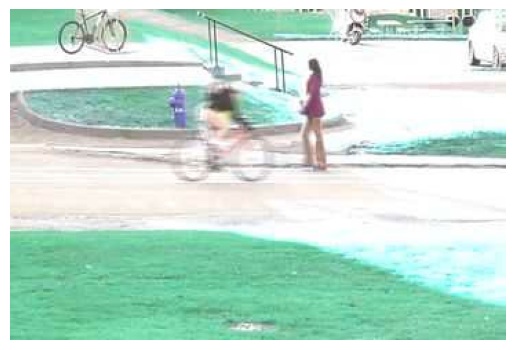

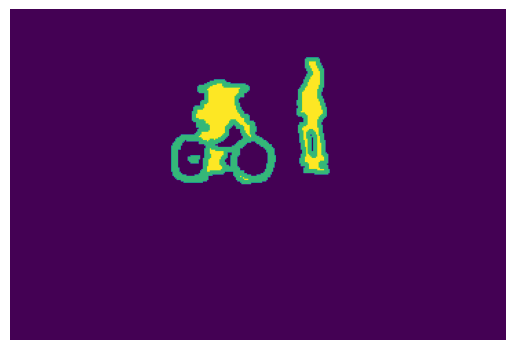

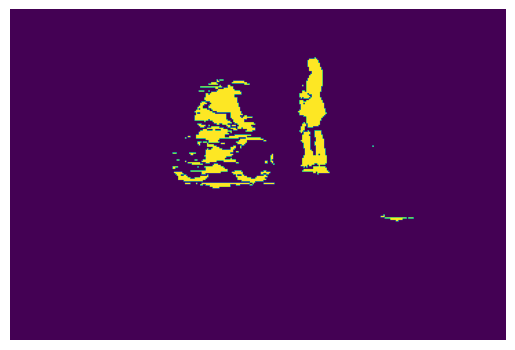

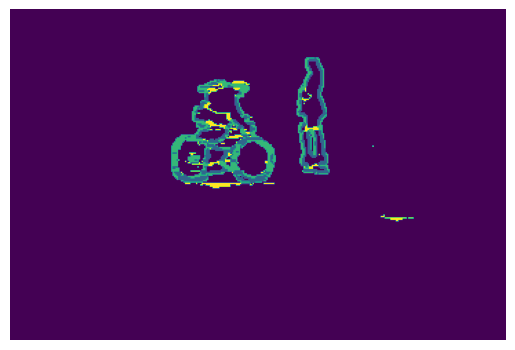

In [118]:
data = [highway, office, pedestrians, PETS2006]
data_ref = [highway_ref, office_ref, pedestrians_ref, PETS2006_ref]
data_name = ["highway", "office", "pedestrians", "PETS2006"]

for data_index in range(2, len(data[0:3])):
    print(f"Dataset - {data_name[data_index]}")
    current_data = data[data_index]
    current_data_ref = data_ref[data_index]

    current_result = classify_difference(current_data, current_data_ref, show_img=0, do_SI=True, do_BR=False)

    # with open(f"{data_name[data_index]}.csv", 'w+', newline='') as file:
    #     writer = csv.writer(file)
    #     writer.writerow(["index", "SI", "BR"])
        
    #     for i in range(0, len(current_result)):
    #         writer.writerow([i, current_result[i][0], current_result[i][1]])